In [2]:
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import importlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import re

In [48]:
# read the excel file   
df = pd.read_excel('/Users/jensknudsen/Desktop/result/overleaf.xlsx')

# Make the rows columns and vis versa
df = df.T
# make the first row the header and remove the first row
df.columns = df.iloc[0]
df = df[1:]

df = df[['Optimal x value for validation for the strategy with x on both sides on optimization for Sharpe Ratio', 'Best Sharpe Ratio for test data for combined based on strategy with x on both sides on the optimization for Sharpe Ratio']]
# rename the columns
df.columns = ['Optimal_X', 'Best_SR']

df = df.T

112000
447400
559400
Average Sharpe Ratio: -0.00011116931433712849


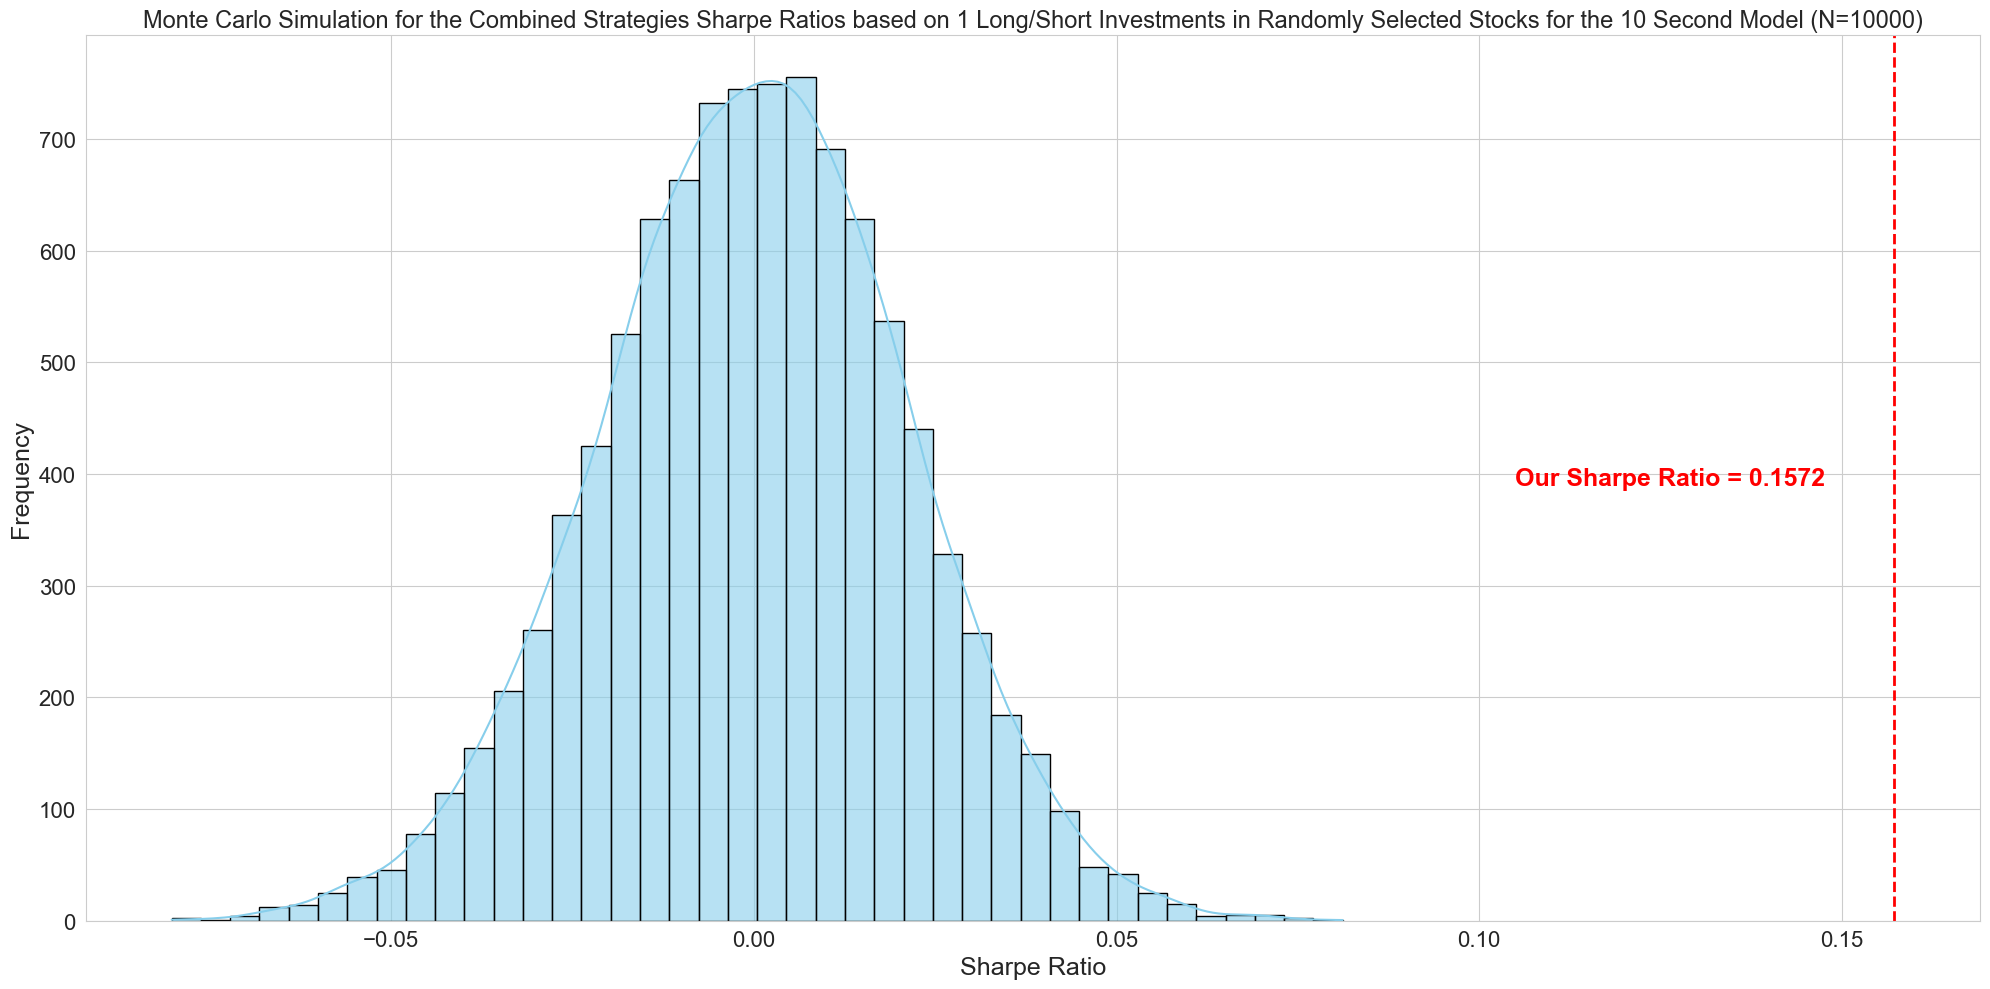

Average Sharpe Ratio: -0.00011116931433712849
Done with 10 seconds model!


In [50]:
time_options = ['0,01', '0,1', '0,5', '1', '5', '10']
for i in time_options:
    selected_time = i # THIS IS THE ONE THAT SELECTS THE TIME INTERVAL FOR ALL THE MODELS DOWN UNDER!!!!! time_options = ['0,01', '0,1', '0,5', '1', '5', '10']

    time_dict = {'0,01': '10L', '0,1': '100L', '0,5': '500L', '1': '1S', '5': '5S', '10': '10S'}
    standardized_dict = {'0,01': 25, '0,1': 2.5, '0,5': 1/2, '1': 1/4, '5': 1/20, '10': 1/40}

    #import the csv file
    label_df_new = pd.read_csv(f'/Users/jensknudsen/Desktop/result/{selected_time}/predictions_depth5_time{time_dict[selected_time]}_window5_predicted.csv')

    val_procent = 0.2

    # Calculate the number of samples that should be in the training set
    num_samples = len(label_df_new) * val_procent
    
    
    def closest_value(input):
        # Adjust the input to the closest higher multiple of 250
        return int(input + (200 - input % 200))
    
    train_samples = closest_value(num_samples)
    
    
    val_df= label_df_new[:train_samples]
    test_df = label_df_new[train_samples:]
    
    print(len(val_df))
    print(len(test_df))
    print(len(test_df)+len(val_df))

    def calculate_combined_for_best_SR(x, df):
        selected_stocks = x
        modified_df = df.copy()

        # Temporarily store indices for largest and smallest adjustments
        smallest_indices = []
        largest_indices = []

        for time, group in df.groupby('Time'):
            # Ensure we have enough stocks to choose from
            if len(group) < selected_stocks * 2:
                continue
            
            # Randomly select indices for smallest and largest without overlap
            indices = np.random.choice(group.index, selected_stocks * 2, replace=False)
            smallest_indices_time, largest_indices_time = indices[:selected_stocks], indices[selected_stocks:]

            # Append to overall lists
            smallest_indices.extend(smallest_indices_time)
            largest_indices.extend(largest_indices_time)

            # Change midquote values to negative for smallest_indices
            modified_df.loc[smallest_indices_time, 'midquote'] = -modified_df.loc[smallest_indices_time, 'midquote']

        # Combine selected indices
        combined_indices = np.union1d(smallest_indices, largest_indices)

        # Select combined indices from modified DataFrame
        filtered_df = modified_df.loc[combined_indices]

        # Sort the dataframe
        filtered_df = filtered_df.sort_values(by='Time')

        # Calculate mean and standard deviation of midquote, then compute Sharpe ratio
        mean_per_time = filtered_df.groupby('Time')['midquote'].mean()
        overall_mean = mean_per_time.mean()
        overall_std = mean_per_time.std()  # ddof=1 for sample standard deviation

        # Handle division by zero or NaN standard deviation
        sharpe_ratio = np.nan if overall_std == 0 else overall_mean / overall_std

        return sharpe_ratio

    def monte_carlo_simulation(df, x, iterations):
        sharpe_ratios = []

        for _ in range(iterations):        
            # Calculate the Sharpe ratio for the selected stocks
            sharpe_ratio = calculate_combined_for_best_SR(x, df)
            sharpe_ratios.append(sharpe_ratio)

        return sharpe_ratios

    # Example usage:
    x = df[i][0]  # Number of stocks to select randomly
    iterations = 10000

    # Perform the simulation
    sharpe_ratios = monte_carlo_simulation(test_df, x, iterations)

    # Output results
    print("Average Sharpe Ratio:", np.nanmean(sharpe_ratios))

    Our_Sharp_Ratio = df[i][1] 

    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Plot the histogram using seaborn for better aesthetics
    plt.figure(figsize=(20, 10))
    sns.histplot(sharpe_ratios, bins=40, kde=True, color='skyblue', edgecolor='black', alpha=0.6)
    plt.axvline(x=Our_Sharp_Ratio, color='red', linestyle='--', linewidth=2)

    # Determine the current plot's x-axis limits
    x_min, x_max = plt.xlim()

    # To place the text further to the left, increase the subtraction value.
    # This approach uses a fixed offset from x_min, ensuring the text is always visible and well-positioned.
    text_offset = 0.2 * (x_max - x_min)  # Adjust this value as needed to move text further to the left.
    text_x_position = max(x_min + 0.01 * (x_max - x_min), Our_Sharp_Ratio - text_offset)  # Ensure it's not too close to the edge

    # Adding annotations for the red line, ensuring it's horizontally aligned and to the left of the line
    plt.text(text_x_position, plt.ylim()[1] * 0.5, f'Our Sharpe Ratio = {Our_Sharp_Ratio:.4f}', 
             color='red', ha='left', va='center', fontsize=18, fontweight='bold')

    plt.xlabel('Sharpe Ratio', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    # make the x and y axis labels bigger
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'Monte Carlo Simulation for the Combined Strategies Sharpe Ratios based on {x} Long/Short Investments in Randomly Selected Stocks for the {selected_time} Second Model (N={iterations})', fontsize=17)
    plt.tight_layout()
    # save the plot
    plt.savefig(f'/Users/jensknudsen/Desktop/result/{selected_time}/overleaf/MC_simulation_combined_{selected_time}.png',dpi=300, bbox_inches='tight')
    plt.show()

    # calculate the mean of the sharpe ratios
    print("Average Sharpe Ratio:", np.nanmean(sharpe_ratios))
    print(f'Done with {selected_time} seconds model!')

